In [1]:
# Set the display width of the Jupyter cells to maximum
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Import libraries
import pylab
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy.stats.stats import pearsonr
%matplotlib inline

# Define to_image function
pixels = ["pixel_{0}".format(i) for i in range(400)] # 20*20 = 400
def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,20,20), axis=-1)

Using TensorFlow backend.


In [29]:
# File paths
datafilenames = ["SharedHits/NormalizedCharge/output_final.h5","SharedHits/AbsoluteCharge/output_final.h5",
                "Shared100NonShared/NormalizedCharge/output_final.h5","Shared100NonShared/AbsoluteCharge/output_final.h5",
                "AllHits/NormalizedCharge/output_final.h5","AllHits/AbsoluteCharge/output_final.h5"]

filenumber = 5
filename = "/uscms_data/d3/bbonham/TrackerProject/Output_of_Postprocess/AllHits/AbsoluteCharge/output_final.h5"
signalstring = "['isSharedHit']==1"
auc=.953
otherVariables = ["trackPt","trackEta","totalADCcount"]

#print "ROC Curve"+"\n"+datafilename[:-16]+"\n"+"Signal: "+signalstring+"\n"+"Area = {:.3f}".format(.95)
print "ROC Curve (Area = {:.3f})".format(auc)+"\nNN Script\n"+filename[60:-16]+"\n"+str(otherVariables)

ROC Curve (Area = 0.953)
NN Script
AllHits/AbsoluteCharge
['trackPt', 'trackEta', 'totalADCcount']


SharedHits/NormalizedCharge
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8505 entries, 0 to 8504
Columns: 407 entries, pixel_78 to pixel_148
dtypes: float64(405), int32(1), int64(1)
memory usage: 26.4 MB
None
Test Data Shape:  (4253, 407)
Train Data Shape:  (4252, 407)
SharedHits/AbsoluteCharge
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8505 entries, 0 to 8504
Columns: 407 entries, pixel_78 to pixel_148
dtypes: float64(405), int32(1), int64(1)
memory usage: 26.4 MB
None
Test Data Shape:  (4253, 407)
Train Data Shape:  (4252, 407)
Shared100NonShared/NormalizedCharge
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12477 entries, 0 to 12476
Columns: 407 entries, pixel_78 to pixel_148
dtypes: float64(405), int32(1), int64(1)
memory usage: 38.8 MB
None
Test Data Shape:  (6239, 407)
Train Data Shape:  (6238, 407)
Shared100NonShared/AbsoluteCharge
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12477 entries, 0 to 12476
Columns: 407 entries, pixel_78 to pixel_148
dtypes: float

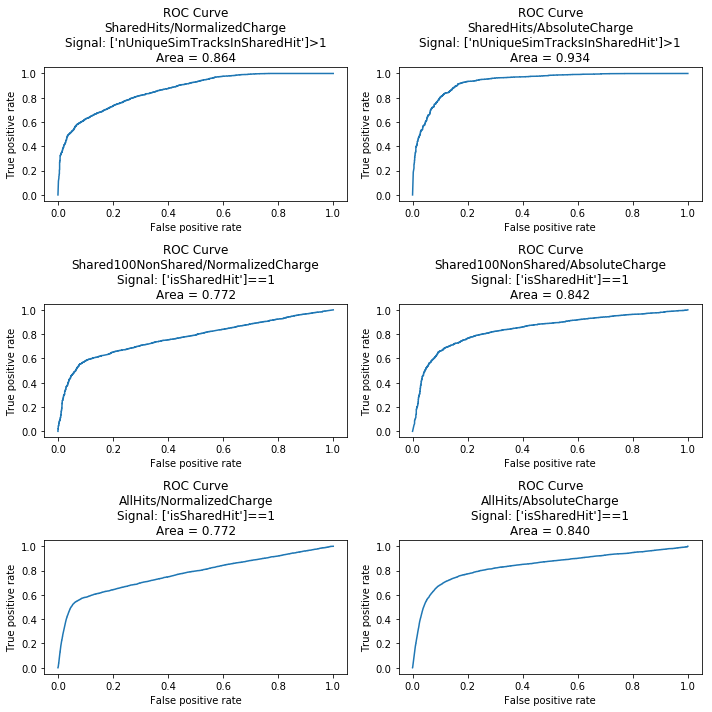

In [8]:
### Loop over 6 data categories and generate the ROC curve for each ###

# File paths
datafilenames = ["SharedHits/NormalizedCharge/output_final.h5","SharedHits/AbsoluteCharge/output_final.h5",
                "Shared100NonShared/NormalizedCharge/output_final.h5","Shared100NonShared/AbsoluteCharge/output_final.h5",
                "AllHits/NormalizedCharge/output_final.h5","AllHits/AbsoluteCharge/output_final.h5"]
# Initiate figure
fig = plt.figure()

# Loop over the data files
for counter,datafilename in enumerate(datafilenames):
    
    ### Import the Data ###
    # Select file you want to use
    filenumber = counter
    datafilename = datafilenames[filenumber]
    
    # Import data
    df = pd.read_hdf("/uscms_data/d3/bbonham/TrackerProject/TrackingDstar/LambaAnalyzer/output_of_postprocess/"+datafilename, 
                     key="df", mode='r')

    # Print dataframe info
    print '\033[1m' + datafilename[:-16] + '\033[0m' # name printed in bold
    print df.info()

    # Shared Hits Signal Region
    if filenumber == 0 or filenumber == 1:
        signalstring = "['nUniqueSimTracksInSharedHit']>1"
        
    # Non-Shared Hits Signal Region
    if filenumber in [2,3,4,5]:
        signalstring = "['isSharedHit']==1"
    
    ### Load the trained model ###
    model = load_model('/uscms/home/bbonham/nobackup/TrackerProject/MergedHits/Brandon/Trained_Models/TrainedModel_'+datafilename[:-16].replace('/','_')+'.h5')
    # Reproduce the train-test split from when you trained the model.
    train_test_seed = 10
    df_train,df_test = train_test_split(df,test_size=0.5,random_state=train_test_seed)
    images_train = to_image(df_train)
    images_test = to_image(df_test)

    # Sanity check: Printout (events, variables). Variables include 400 pixels, and a few others you can find using df.info()
    print "Test Data Shape: ",df_test.shape
    print "Train Data Shape: ",df_train.shape
    
    ### Add ROC curve subplot to main plot ###
    # Setup
    ret = model.predict(images_test)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(keras.utils.to_categorical(eval("df_test"+signalstring))[:,1], ret[:,1])
    from sklearn.metrics import auc
    auc_keras = auc(fpr_keras, tpr_keras)
    auc = np.trapz(tpr_keras,fpr_keras)
    
    # Add subplot
    ax = fig.add_subplot(3,2,counter+1)
    ax.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
    ax.set_title("ROC Curve"+"\n"+datafilename[:-16]+"\n"+"Signal: "+signalstring+"\n"+"Area = {:.3f}".format(auc))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')

# Plot & Save
fig.set_size_inches(10, 10)
fig.tight_layout()
plt.savefig("ROC_Curves.png")
plt.show()